## ATP Men's Tennis Predictions (2022)

In this tennis project, I look at the data containing results for the men’s ATP Tour tournaments as well as a range of ITF-level events (the Olympic Tennis Tournament and the Davis Cup). Those are the most prestgious tennis tournaments which the majority of top-tier athletes take part in.

The goal is to learn to predict the outcome of tennis matches based on the available information about players' personal characteristics and previous matches stats. I will try to solve two types of problems: regression and binary classification problems.

In regression problem, I aim to predict the difference in final score between the winner and the loser. In classification problem, I will simply try to answer which of the two player is more likely to win and what the odds are. 

Initially, there are 23 yearly datasets that contain the information on all tennis matches taking place from January 2000 to December 2021.

Below is the meaning of possibly confusing columns of the dataset:

* w/l_ace = absolute number of aces performed by the winner/loser
* w/l_df = number of double faults performed by the winner/loser
* w/l_svpt = total serve points performed by the winner/loser
* w/l_1stin = number of 1st serves in performed by the winner/loser
* w/l_1st won = points won on 1st serve by the winner/loser
* w/l_2ndwon = points won on 2nd serve by the winner/loser
* w/l_SvGms = serve games performed by the winner/loser
* w/l_bpSaved = number of break points saved by the winner/loser
* w/l_bpFaced = number of break points faced by the winner/loser
* winner/loser_entry = indication of whether the winner/loser gained indirect acceptance (i.e. as a qualifier or wild card) into the main draw of a tournament
* winner/loser_hand = winner's/loser's dominant hand
* winner/loser_ht = winner's/loser's height
* winner/loser_ioc = winner's/loser's home country

#### Data cleaning and feature engineering 

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Importing the following dataframes and merging them into one dataset:

In [3]:
import glob
print('All csv files in data directory:', glob.glob('/content/gdrive/My Drive/Brainstation/ATP/atp_matches_*.csv'))

All csv files in data directory: []


In [4]:
file_name = '/content/gdrive/My Drive/Tennis/ATP/atp_matches_{}.csv'
atp_l = []
for i in range(2000, 2022):
    atp_l.append(pd.read_csv(file_name.format(i)))
atp = pd.concat(atp_l)

Let's take a look at the fisrt five rows and the information about the dataset. 

In [5]:
atp.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-339,Adelaide,Hard,NaN,A,20000103,1,102358,1.0,NaN,...,37.0,25.0,13.0,9.0,2.0,4.0,4.0,1850.0,56.0,490.0
1,2000-339,Adelaide,Hard,NaN,A,20000103,2,103819,NaN,NaN,...,15.0,13.0,12.0,8.0,0.0,3.0,64.0,515.0,91.0,404.0
2,2000-339,Adelaide,Hard,NaN,A,20000103,3,102998,NaN,NaN,...,59.0,49.0,22.0,16.0,4.0,5.0,58.0,544.0,105.0,243.0
3,2000-339,Adelaide,Hard,NaN,A,20000103,4,103206,7.0,NaN,...,22.0,12.0,8.0,8.0,1.0,6.0,27.0,928.0,54.0,602.0
4,2000-339,Adelaide,Hard,NaN,A,20000103,5,102796,3.0,NaN,...,40.0,25.0,16.0,10.0,7.0,10.0,15.0,1244.0,154.0,219.0


In [6]:
atp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63619 entries, 0 to 2726
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          63619 non-null  object 
 1   tourney_name        63619 non-null  object 
 2   surface             63501 non-null  object 
 3   draw_size           4189 non-null   float64
 4   tourney_level       63619 non-null  object 
 5   tourney_date        63619 non-null  int64  
 6   match_num           63619 non-null  int64  
 7   winner_id           63619 non-null  int64  
 8   winner_seed         26433 non-null  float64
 9   winner_entry        7698 non-null   object 
 10  winner_name         63619 non-null  object 
 11  winner_hand         63599 non-null  object 
 12  winner_ht           58744 non-null  float64
 13  winner_ioc          63619 non-null  object 
 14  winner_age          63605 non-null  float64
 15  loser_id            63619 non-null  int64  
 16  loser

To begin with, I drop several columns which will not be useful in our case, such as tournament ID, the number of match, player's seed (which is obviously correlated with rank), etc. I also drop draw size column which is empty. We can also notice that out of 63,619 observations the majority of variables do not have as many NaN values. The only columns which are lacking observations are 'winner/loser seed' (which will be dropped) and 'winner/loser entry'. The latter one contains quite important information about the players, therefore it will be necessary to transform the variable in order to reduce the number of missing values.

In [7]:
atp = atp.drop(['draw_size', 'tourney_id', 'match_num', 'winner_seed', 'loser_seed', 'best_of'], axis = 1)

Next I check if there are any duplicates - turns out there are none:

In [8]:
atp[atp.duplicated()]

,tourney_name,surface,tourney_level,tourney_date,winner_id,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points


To check the data for high cardinality, it is necessary to investigate columns and find out whether any of categorical variables has a large number of unique values:

In [9]:
atp.select_dtypes(include=[object]).nunique()

tourney_name      1682
surface              5
tourney_level        5
winner_entry         7
winner_name       1569
winner_hand          3
winner_ioc         105
loser_entry          8
loser_name        2308
loser_hand           3
loser_ioc          114
score            11247
round                9
dtype: int64

Apparently, tourney/winner/loser name columns have a high number of unique values - more than one thousand. That's not unexpected, but that's not a problem as these variables won't be used in the analysis. However, there are two variables, both standing for players' nationality, which might be useful. To get rid of a huge number of categories, those will be transformed later. The score column will be transormed as well into a target variable.

Then it is necessary to convert categorical data to numerical. For 'surface', 1 means the most used surface while 4 means the least used surface according to the frequency below. None values will be dropped as there are only 80 of them:

In [10]:
atp['surface'].value_counts()

Hard      34323
Clay      20685
Grass      6389
Carpet     2024
None         80
Name: surface, dtype: int64

In [11]:
atp = atp[atp['surface'] != 'None']
atp['surface'] = atp['surface'].map({'Hard' : 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4})

Same approach is used for player's dominant hand except for the fact that right hand will be a default characteristic and marked as zero. The tournaments' level variable is converted according to the ranking of the tournaments with Grand Slams as the most prestigious ones.

In [12]:
#R - right-handed, L - left-handed, U - ambidextrous
atp['winner_hand'] = atp['winner_hand'].map({'R' : 0, 'L' : 1, 'U' : 2})
atp['loser_hand'] = atp['loser_hand'].map({'R' : 0, 'L' : 1, 'U' : 2})

In [13]:
#A - ATP250 & ATP500, M - ATP Masters 1000, G - Grand Slam, D - Davis Cup, F - Finals & Finals Next Gen
atp['tourney_level'] = atp['tourney_level'].map({'G': 1, 'F': 2, 'M': 3, 'A': 4, 'D': 5})

It was mentioned that 'winner/loser entry' columns contain a lot of null values which is expected since the majority of the players get to the main draw by their rank, and there are not so many exceptions such as wild cards or qualifiers. However, such information is still valuable, and I decided to create new binary columns; each would indicate particular special conditions under which previously unqualified players got a chance to play in the main draw:

In [14]:
#Q - qualifier; WC - wild card; LL - lucky loser, ALT - alternate
#PR - protected ranking, SE - special extempt
for i in ['winner', 'loser']:
    atp['{}_Q'.format(i)] = np.where(atp['{}_entry'.format(i)] == 'Q', 1, 0)
    atp['{}_WC'.format(i)] = np.where(((atp['{}_entry'.format(i)] == 'WC') | (atp['{}_entry'.format(i)] == 'SE')), 1, 0)
    atp['{}_LL'.format(i)] = np.where(((atp['{}_entry'.format(i)] == 'LL') | (atp['{}_entry'.format(i)] == 'ALT')), 1, 0)

Now it's also necessary to start preparing separate dataset for the classification problem. Since now there are columns for winners and losers, we need to shuffle the observations to be able to create binary dependent variable. To make the dataset balanced, I create 45% of 0's and 65% of 1's:

In [15]:
df1, df2 = train_test_split(atp, test_size=0.45)

In [16]:
df1.columns = ['tourney_name', 'surface', 'tourney_level', 'tourney_date', 'p1_id',
       'p1_entry', 'p1_name', 'p1_hand', 'p1_ht', 'p1_ioc',
       'p1_age', 'p2_id', 'p2_entry', 'p2_name', 'p2_hand',
       'p2_ht', 'p2_ioc', 'p2_age', 'score', 'round', 'minutes',
       'p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 'p1_SvGms',
       'p1_bpSaved', 'p1_bpFaced', 'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn',
       'p2_1stWon', 'p2_2ndWon', 'p2_SvGms', 'p2_bpSaved', 'p2_bpFaced',
       'p1_rank', 'p1_rank_points', 'p2_rank', 'p2_rank_points', 'p1_Q', 'p1_WC', 'p1_LL', 'p2_Q', 'p2_WC',
       'p2_LL']
df1['outcome'] = 1

In [17]:
df2.columns = ['tourney_name', 'surface', 'tourney_level', 'tourney_date', 'p2_id',
       'p2_entry', 'p2_name', 'p2_hand', 'p2_ht', 'p2_ioc',
       'p2_age', 'p1_id', 'p1_entry', 'p1_name', 'p1_hand',
       'p1_ht', 'p1_ioc', 'p1_age', 'score', 'round', 'minutes',
       'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon', 'p2_SvGms',
       'p2_bpSaved', 'p2_bpFaced', 'p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn',
       'p1_1stWon', 'p1_2ndWon', 'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced',
       'p2_rank', 'p2_rank_points', 'p1_rank', 'p1_rank_points', 'p2_Q', 'p2_WC', 'p2_LL', 'p1_Q', 'p1_WC',
       'p1_LL']
df2['outcome'] = 0

In [18]:
atp_class = pd.concat([df1, df2])

While age and height are extremely important, it is worth introducing new variables describing the difference in height/age between the two players. In my opinion, those have more explanationary power and will help to get better predictions:

In [19]:
atp['ht_diff'] = atp['winner_ht'] - atp['loser_ht']
atp['age_diff'] = atp['winner_age'] - atp['loser_age']

atp_class['ht_diff'] = atp_class['p1_ht'] - atp_class['p2_ht']
atp_class['age_diff'] = atp_class['p1_age'] - atp_class['p2_age']

In [20]:
atp = atp.dropna(subset=['ht_diff', 'winner_hand', 'loser_hand'])

atp_class = atp_class.dropna(subset=['ht_diff', 'p1_hand', 'p2_hand'])

At the beginning I found out that there are two categorical variables with many categories which can be used further. However, it is not that important to know precisely about a player's nationality. What can be informative is whether a player is from a leading tennis nation (i.e. which has huge internal competition, tennis traditions, tennis celebrities). I created a binary varible indicating that. The player is assigned with a value 1 if he is from any of 15 countries with the biggest number of representatives in the ATP tour, and 0 otherwise:

In [21]:
big_countries = ['ESP', 'FRA', 'USA', 'ARG', 'GER', 'RUS', 'SUI', 'CZE', 'CRO', 
                 'AUS', 'SRB', 'ITA', 'SWE', 'GBR', 'BEL']
for i in ['winner', 'loser']:
    atp['{}_sign_country'.format(i)] = np.where(atp['{}_ioc'.format(i)].isin(big_countries), 1, 0)

for i in ['p1', 'p2']:
    atp_class['{}_sign_country'.format(i)] = np.where(atp_class['{}_ioc'.format(i)].isin(big_countries), 1, 0)

Below is the format of the score variable:

In [22]:
atp['score'].head(3)

0           6-3 6-4
1           6-1 6-4
2    3-6 7-6(5) 6-4
Name: score, dtype: object

Of course, we can't use it to predict the outcome of the match since it's string. Therefore, the scores have been split by sets; NaN values were dropped. The incomplete matches (for example, match could end due to injury of one player) were also dropped. I also got rid of inconsistencies (such as 0-0 in the first/second set which can't be true).  

In [23]:
atp[['set1', 'set2', 'set3', 'set4', 'set5', 'set6']] = atp.score.str.split(" ", expand=True,)

atp = atp[(atp['set1'] != 'RET') & (atp['set1'] != 'DEF') & (atp['set1'] != '1-Apr') & (atp['set1'] != '3-Jun') & (atp['set1'] != 'W/O') & (atp['set1'] != 'Default')]
atp = atp[(atp['set2'] != 'RET') & (atp['set2'] != 'DEF') & (atp['set2'] != 'W/O') & (atp['set2'] != 'Default')]
atp = atp[(atp['set3'] != 'RET') & (atp['set3'] != 'Played') & (atp['set3'] != 'DEF') & (atp['set3'] != 'Default') & (atp['set3'] != '[3-10]') & (atp['set3'] != '[7-10]')]
atp = atp[(atp['set4'] != 'RET') & (atp['set4'] != 'and') & (atp['set4'] != 'DEF') & (atp['set4'] != 'Default')]
atp = atp[(atp['set5'] != 'RET') & (atp['set5'] != 'unfinished') & (atp['set5'] != 'DEF') & (atp['set5'] != 'Default') & (atp['set5'] != 'Def.')]

In [24]:
for i in range(1,6):
    atp['set{}'.format(i)] = np.where(((atp['set{}'.format(i)] == '') | (atp['set{}'.format(i)].isna())), '0-0', atp['set{}'.format(i)])

In [25]:
atp = atp[(atp['set1'] != '0-0') & (atp['set2'] != '0-0')]

In [26]:
for i in range (1,6):
    atp[['set{}_w'.format(i), 'set{}_l'.format(i)]] = atp['set{}'.format(i)].str.split("-", expand=True,)

In [27]:
atp = atp[(atp['set3_w'] != '[11') & (atp['set3_w'] != '[12')]

In [28]:
for i in [1, 2, 4]:
    atp['set{}_l'.format(i)] = atp['set{}_l'.format(i)].astype(str).str[:1].astype(int)
    
for j in [3, 5]:
    atp['set{}_l'.format(j)] = atp['set{}_l'.format(j)].astype(str).str[:2].str.replace('(','').astype(int)
    
for k in range(1, 6):
    atp['set{}_w'.format(k)] = atp['set{}_w'.format(k)].astype(int)

In [29]:
atp = atp.drop(['round', 'winner_rank_points', 'loser_rank_points', 'winner_ioc', 'loser_ioc', 'winner_entry', 
                'loser_entry','set1', 'set2', 'set3', 'set4', 'set5', 'set6'], axis = 1)

Using the absolute numbers of matches' stats (the number of aces, saved breakpoints, successful serves, etc), we can calculate the percentages. Also, the total number of points won by the winner and the loser were calculated.

In [30]:
for i in ['w', 'l']:
    atp['total_{}_pts'.format(i)] = atp['set1_{}'.format(i)] + atp['set2_{}'.format(i)] + atp['set3_{}'.format(i)] + atp['set4_{}'.format(i)] + atp['set5_{}'.format(i)]
    atp['{}_bpsaved_percentage'.format(i)] = np.where(atp['{}_bpFaced'.format(i)] != 0, round((100*atp['{}_bpSaved'.format(i)])/atp['{}_bpFaced'.format(i)], 2), 0)
    atp['{}_1stIn_percentage'.format(i)] = round((100*atp['{}_1stIn'.format(i)])/atp['{}_svpt'.format(i)], 2)
    atp['{}_1stWon_percentage'.format(i)] = round((100*atp['{}_1stWon'.format(i)])/atp['{}_svpt'.format(i)], 2)
    atp['{}_2ndWon_percentage'.format(i)] = round((100*atp['{}_2ndWon'.format(i)])/atp['{}_svpt'.format(i)], 2)

for i in ['p1', 'p2']:
    atp_class['{}_bpsaved_percentage'.format(i)] = np.where(atp_class['{}_bpFaced'.format(i)] != 0, round((100*atp_class['{}_bpSaved'.format(i)])/atp_class['{}_bpFaced'.format(i)], 2), 0)
    atp_class['{}_1stIn_percentage'.format(i)] = round((100*atp_class['{}_1stIn'.format(i)])/atp_class['{}_svpt'.format(i)], 2)
    atp_class['{}_1stWon_percentage'.format(i)] = round((100*atp_class['{}_1stWon'.format(i)])/atp_class['{}_svpt'.format(i)], 2)
    atp_class['{}_2ndWon_percentage'.format(i)] = round((100*atp_class['{}_2ndWon'.format(i)])/atp_class['{}_svpt'.format(i)], 2)

Finally, the target variable was created for the first dataset - score difference. Also, differences in key match stats were calculated - those are expected to be one of the most importants features in the analysis.

In [31]:
atp['pts_diff'] = atp['total_w_pts'] - atp['total_l_pts'] #target variable
atp['bpsaved_diff'] = atp['w_bpsaved_percentage'] - atp['l_bpsaved_percentage']
atp['aces_diff'] = atp['w_ace'] - atp['l_ace']
atp['df_diff'] = atp['w_df'] - atp['l_df']
atp['1stIn_diff'] = atp['w_1stIn_percentage'] - atp['l_1stIn_percentage']
atp['1stWon_diff'] = atp['w_1stWon_percentage'] - atp['l_1stWon_percentage']
atp['2ndWon_diff'] = atp['w_2ndWon_percentage'] - atp['l_2ndWon_percentage']

atp_class['bpsaved_diff'] = atp_class['p1_bpsaved_percentage'] - atp_class['p2_bpsaved_percentage']
atp_class['aces_diff'] = atp_class['p1_ace'] - atp_class['p2_ace']
atp_class['df_diff'] = atp_class['p1_df'] - atp_class['p2_df']
atp_class['1stIn_diff'] = atp_class['p1_1stIn_percentage'] - atp_class['p2_1stIn_percentage']
atp_class['1stWon_diff'] = atp_class['p1_1stWon_percentage'] - atp_class['p2_1stWon_percentage']
atp_class['2ndWon_diff'] = atp_class['p1_2ndWon_percentage'] - atp_class['p2_2ndWon_percentage']

Finally, all other NaN values were dropped, and we're left with roughly 48 thousand observations.

In [32]:
atp.dropna(inplace=True)

In [33]:
atp_class = atp_class.drop(['round', 'p1_rank_points', 'p2_rank_points', 'p1_ioc', 'p2_ioc', 'p1_entry', 
                'p2_entry','score'], axis = 1)

In [34]:
atp_class.dropna(inplace=True)

#### Regression Problem

Below are the features which might be used in the subsequent analysis. Those are the variables which can greatly affect the outcome of a tennis match. Apparently, previous matches' stats can be used to determine whether any given player has chances to win based on his past performance. Personal characteristics such as age and height are important as well: younger and taller players might have an advantage, though there are some exceptions (i.e. Federer). Surface varible is extremely informative since players generally can't show the same quality of play on all surfaces. Those who hold wild cards or got into the main draw as lucky losers also have lower chances of winning against higher-ranked competitors.

In [35]:
features = ['surface', 'tourney_level', "winner_hand", "loser_hand", "minutes", "winner_rank", "loser_rank",
           'winner_Q', 'winner_WC', 'winner_LL', 'loser_Q', 'loser_WC', 'loser_LL', 'ht_diff', 'winner_sign_country',
           'loser_sign_country', 'age_diff', 'bpsaved_diff', 'aces_diff', 'df_diff', '1stIn_diff', '1stWon_diff',
           '2ndWon_diff', 'pts_diff']

My dependent (target) variable is difference in final score between the first and the second player (i.e. winner and loser). Independent variables are listed above. Since the target variable is continuous, we need to apply regression methods. As a first step, I will perform multiple linear regression using all the variables. In general, you do not need to center or standardize your data for multiple regression, so I will not scale my data before performing this method.

In [36]:
X = atp[features].drop(['pts_diff'], axis = 1)
y = atp['pts_diff']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [38]:
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
print("The coefficient of determination R^2 for train data is", round(LinReg.score(X_train, y_train), 4))
print("The coefficient of determination R^2 for test data is", round(LinReg.score(X_test, y_test), 4))

The coefficient of determination R^2 for train data is 0.7025
The coefficient of determination R^2 for test data is 0.7037


First of all, we can notice that the model is not overfitted since $R^2$ for test data does not differ from the coefficient of $R^2$ for train data. In general, all chosen explanatory variables give us the score of 70%, which is not bad for the simplest regression method.

Of course, the number of features is too big right now (23). It is highly likely that many of them are not as important and we can probably reduce the number of variables. To do so, I perform the feature selection method which evaluates feature importances and selects the most relevant features:

In [39]:
feature_rank = feature_selection.mutual_info_classif(X, y)
feature_rank_df = pd.DataFrame(list(zip(features, feature_rank)), columns=['Feature', 'Score'])
feature_rank_df.sort_values(by='Score', ascending = False).head(10)

,Feature,Score
17,bpsaved_diff,0.295646
4,minutes,0.249527
21,1stWon_diff,0.148494
1,tourney_level,0.065595
22,2ndWon_diff,0.045732
18,aces_diff,0.029107
5,winner_rank,0.018672
19,df_diff,0.017048
0,surface,0.006528
6,loser_rank,0.005724


We can see that the majority of features can be eliminated since they are not as relevant. Fisrt, I put the threshold of 0.05 and performed multiple linear regression again, but $R^2$ dropped significantly. That's why I decided to stick to the threshold of 0.01:

In [40]:
selected = [x for x in feature_rank_df[feature_rank_df['Score'] >= 0.01]['Feature']]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X[selected], y, test_size=0.3)

In [42]:
LinReg2 = LinearRegression()
LinReg2.fit(X_train, y_train)
print("The coefficient of determination R^2 for train data is", round(LinReg2.score(X_train, y_train), 4))
print("The coefficient of determination R^2 for test data is", round(LinReg2.score(X_test, y_test), 4))

The coefficient of determination R^2 for train data is 0.7012
The coefficient of determination R^2 for test data is 0.7029


Now we can see that even though we used only 8 out of 23 initial features, $R^2$ for test data is even just a tiny bit lower (<1%). Thus, I will continue to use these selected features.

Although there is no overfitting according to $R^2$, it would also be helpful to check whether there is collinearity, which would make estimators inconsistent. To check that, I'll take a look at the correlation between selected dependent variables:

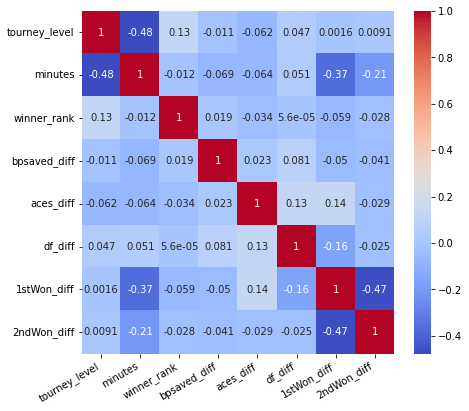

In [43]:
fig = plt.figure(figsize=(7, 7));
sns.heatmap(X[selected].corr(), annot = True, cmap='coolwarm');
fig.autofmt_xdate()
plt.show()

The highest coefficient of correlation (in absolute value) is between the tourney level and the length of the matches. However, it does not even exceed -0.5 which means that there should not be multicollinearity. Therefore, there is no need in performing either Ridge or Lasso Regression.

While linear regression is one of the most common methods, it is not as flexible because it can't follow non-linear dependencies. If we use more complex methods, there is a high chance we'll be able to identify trends and patterns better.

To begin with, SVM method will be performed. Although it is usually used for classification problems, SVM can also be used as a regression method; it is called the Support Vector Regression, and it uses the same principles as the SVM for classification. Since it is a kernel method, it is based on distance. Therefore, we need to scale the data first.

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
expdf = pd.concat([X[selected], y], axis = 1)
scaler.fit(expdf)
df_scaled = scaler.transform(expdf)

In [45]:
X_scaled = df_scaled[:, :-1]
y_scaled = df_scaled[:, -1]

In [46]:
Xsc_train, Xsc_test, ysc_train, ysc_test = train_test_split(X_scaled, y_scaled, test_size=0.3)

In [47]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(Xsc_train, ysc_train)

SVR()

In [48]:
print("The coefficient of determination R^2 for train data is", round(svr.score(Xsc_train, ysc_train), 4))
print("The coefficient of determination R^2 for test data is", round(svr.score(Xsc_test, ysc_test), 4))

The coefficient of determination R^2 for train data is 0.7866
The coefficient of determination R^2 for test data is 0.7735


Now we can see a substantial increase in the $R^2$ coefficient compared to multiple linear regression - more than 8% for train data and about 7% for test data. This might be explained by the fact that this method used RBF kernel which can track non-linear trends (unlike linear regression). Also, there is no overfitting or underfitting since both coefficients are almost similar. 

The next widespread but very powerful method is Random Forest. RF is a tree-based model and hence does not require feature scaling. It is quite hard to determine the best parameters for this method; that's why I will use GridSearchCV which search over specified parameters to find the best one.

In [49]:
parameters = {'max_depth': list(range(1, 15)), 'min_samples_leaf': list(range(1,10))}

In [50]:
rf = RandomForestRegressor()
gcv = GridSearchCV(rf, parameters, n_jobs = -1, cv = 5)

In [51]:
gcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

As GridSearch determined, the best score can be reached by using max_depth = 13 and min_samples_leaf = 3:

In [52]:
gcv.best_params_

{'max_depth': 13, 'min_samples_leaf': 3}

In [53]:
rfm = RandomForestRegressor(max_depth = 13, min_samples_leaf = 3)
rfm.fit(X_train, y_train)
print('The coefficient of determination R^2 for train data is', round(rfm.score(X_train, y_train), 4))
print('The coefficient of determination R^2 for test data is', round(rfm.score(X_test, y_test), 4))

The coefficient of determination R^2 for train data is 0.8829
The coefficient of determination R^2 for test data is 0.7645


Although $R^2$ is higher than in linear regression case, RF regressor does not perform as good as SVR with rbf kernel. Also, we can observe some overfitting since the measure for train data is 12% larger than for test data.

It would also be worth trying another method which is called Gradient Boosting. GB and RF are quite similar to each other in many ways; however, they differ in the way the trees are built, and GB might often perform better.

After parameters tuning, I obtained the following result:

In [54]:
from sklearn.ensemble import GradientBoostingRegressor 

In [55]:
gbrt=GradientBoostingRegressor(n_estimators = 100, max_depth = 7, min_samples_leaf = 2, max_features= 5) 
gbrt.fit(X_train, y_train)
print('The coefficient of determination R^2 for train data is', round(gbrt.score(X_train, y_train), 4)) #836 & 775
print('The coefficient of determination R^2 for test data is', round(gbrt.score(X_test, y_test), 4))

The coefficient of determination R^2 for train data is 0.8301
The coefficient of determination R^2 for test data is 0.7782


What we can see is that this model slightly outperforms SVR and therefore is better than all other models. However, the difference in $R^2$ is quite negligible.

There is also one more method which has been developed recently. It takes into account categorical variables and therefore might explain trends better. Since feature selection method indicated that tourney_level variable (which is categorical) is important, we can try this type of Regressor:

In [58]:
from catboost import CatBoostRegressor
from catboost import Pool

In [59]:
categorical_features_indices = np.array([0])

In [71]:
cbr = CatBoostRegressor(iterations = 93,
                          depth = 7 ,
                          use_best_model = True, learning_rate = 0.25)

In [72]:
cbr.fit(X_train, y_train,
          cat_features = categorical_features_indices, eval_set=(X_test, y_test))

0:	learn: 2.4568802	test: 2.4449418	best: 2.4449418 (0)	total: 40.2ms	remaining: 3.7s
1:	learn: 2.2385802	test: 2.2288859	best: 2.2288859 (1)	total: 90.7ms	remaining: 4.13s
2:	learn: 2.0697791	test: 2.0590189	best: 2.0590189 (2)	total: 135ms	remaining: 4.06s
3:	learn: 1.8622706	test: 1.8497164	best: 1.8497164 (3)	total: 174ms	remaining: 3.87s
4:	learn: 1.7265935	test: 1.7126438	best: 1.7126438 (4)	total: 215ms	remaining: 3.79s
5:	learn: 1.6293898	test: 1.6127398	best: 1.6127398 (5)	total: 268ms	remaining: 3.89s
6:	learn: 1.5646204	test: 1.5461551	best: 1.5461551 (6)	total: 284ms	remaining: 3.49s
7:	learn: 1.5157475	test: 1.4962779	best: 1.4962779 (7)	total: 323ms	remaining: 3.43s
8:	learn: 1.4863741	test: 1.4677790	best: 1.4677790 (8)	total: 352ms	remaining: 3.29s
9:	learn: 1.4583063	test: 1.4402360	best: 1.4402360 (9)	total: 391ms	remaining: 3.24s
10:	learn: 1.4369891	test: 1.4199453	best: 1.4199453 (10)	total: 425ms	remaining: 3.17s
11:	learn: 1.4213175	test: 1.4052539	best: 1.405253

In [73]:
print(cbr.score(X_train, y_train))
print(cbr.score(X_test, y_test))

0.7919417573733079
0.7778822534692107


Having performed 100 itirations, the algorithm detected that the highest $R^2$ could be achieved at the 97th itiration. This model performs as well as the GB model; however, it doesn't add any value on top of it as the score is identical.

Finally, I check the performance of ANN. I chose MSE as a loss function as it is the default loss to use for regression problems. In the hidden layers, the activation function is ReLu - it is considered to be one of the best functions for neural nets. In the output layer with one node, I use linear activation function because the target variable is continuous:  

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.layers.core import Dropout

In [77]:
epoc = 50 #@param {type:"slider", min:0, max:100, step:1}

In [78]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='normal'))
model.add(Dense(28,activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
model.fit(X_train, y_train, epochs=epoc, callbacks = [EarlyStopping(monitor='mse', patience=2)])

Epoch 1/50
1051/1051 [==============================] - 5s 3ms/step - loss: 3.2031 - mse: 3.2031
Epoch 2/50
1051/1051 [==============================] - 2s 2ms/step - loss: 2.3237 - mse: 2.3237
Epoch 3/50
1051/1051 [==============================] - 2s 2ms/step - loss: 2.1272 - mse: 2.1272
Epoch 4/50
1051/1051 [==============================] - 2s 2ms/step - loss: 2.0109 - mse: 2.0109
Epoch 5/50
1051/1051 [==============================] - 2s 2ms/step - loss: 1.9597 - mse: 1.9597
Epoch 6/50
1051/1051 [==============================] - 2s 2ms/step - loss: 1.9353 - mse: 1.9353
Epoch 7/50
1051/1051 [==============================] - 2s 2ms/step - loss: 1.9116 - mse: 1.9116
Epoch 8/50
1051/1051 [==============================] - 2s 2ms/step - loss: 1.8988 - mse: 1.8988
Epoch 9/50
1051/1051 [==============================] - 2s 2ms/step - loss: 1.8879 - mse: 1.8879
Epoch 10/50
1051/1051 [==============================] - 2s 2ms/step - loss: 1.8771 - mse: 1.8771
Epoch 11/50
1051/1051 [======

In [79]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [80]:
from sklearn.metrics import r2_score

In [81]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.770
The R2 score on the Test set is:	0.770


This model performs a bit worse than GB and catboost but better than others. Since we use linear activation function, the last layer will be a linear function of the first layer. So probably hidden layers are not as useful in this case, that's why we didn't observe significant improvement of the score.

#### Classification Problem

In this part, I will try to predict whether a particular player will win if he plays agains some other player. So, it's a binary classification problem. The features used for this task are similar to ones used in the regression analysis.

In [82]:
features = ['surface', 'tourney_level', "p1_hand", "p2_hand", "minutes", "p1_rank", "p2_rank",
           'p1_Q', 'p1_WC', 'p1_LL', 'p2_Q', 'p2_WC', 'p2_LL', 'ht_diff', 'p1_sign_country',
           'p2_sign_country', 'age_diff', 'bpsaved_diff', 'aces_diff', 'df_diff', '1stIn_diff', '1stWon_diff',
           '2ndWon_diff', 'outcome']

In [83]:
X = atp_class[features].drop(['outcome'], axis = 1)
y = atp_class['outcome']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

First of all, the most common, easiest and sometimes most efficient approach is logistic regression:

In [85]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
print("The accuracy for train data is", round(LogReg.score(X_train, y_train), 4))
print("The accuracy for test data is", round(LogReg.score(X_test, y_test), 4))

The accuracy for train data is 0.9346
The accuracy for test data is 0.9357


Apparently, this methods works fine with our data, giving the accuracy of more than 93% for both train and test sets. To make sure that the model is correct, let's take a look at the classification report and confusion matrix:

In [86]:
y_test_preds = LogReg.predict(X_test)

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6644
           1       0.94      0.94      0.94      8234

    accuracy                           0.94     14878
   macro avg       0.93      0.94      0.94     14878
weighted avg       0.94      0.94      0.94     14878



Here we can notice that both precision and recall measures are high for two classes. That is supported by high values of F1 score. Therefore, the classifier works well in both directions.

In [88]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_preds))

[[6167  477]
 [ 479 7755]]


The confusion matrix is a way of tabulating the number of misclassifications, i.e. the number of predicted classes which ended up in a wrong classification bin based on the true classes.

The diagonal elements show the number of correct classifications for each class. The off-diagonal elements provides the misclassifications: 477 of the class 0 were misclassified as 1; 479 of the class 1 were misclassified as 0. In total, it makes 956 misclassifications out of roughly 15 thousand, which is obviously a good result.

As a next step, I want to check whether it is possible to reduce the dimensions of the data since now there are quite a lot of explanatory variables which makes the model complicated. So, it is necessary to scale data first and then apply PCA and see if some of the components explain the vast majority of the variance:

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [90]:
from sklearn.decomposition import PCA
model_pca = PCA().fit(X_scaled)

Below is the graph showing how much of the variance each component explains:

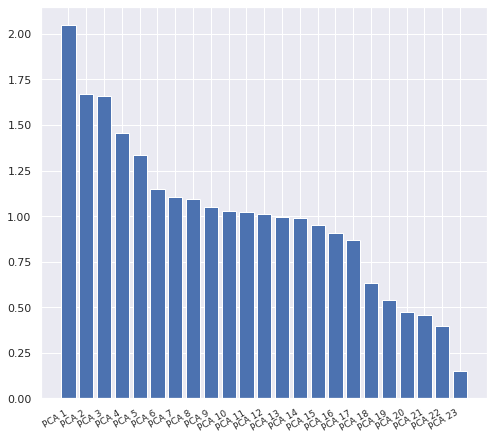

In [91]:
sns.set()
fig = plt.figure(figsize=(8, 8));
PCA_components = ["PCA " + str(i) for i in np.arange(1,24)]
plt.bar(PCA_components,model_pca.explained_variance_)
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=9)
plt.show()

Many of the components are quite important and explain a huge part of the total variance. Therefore, it's not that easy to drop even a small number of them. Even if we stick to the first 10 components, the accuracy will drop significantly (by 10%):

In [92]:
pca = PCA(n_components= 10).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [93]:
LogReg3 = LogisticRegression()
LogReg3.fit(X_pca, y)
print("The accuracy for train data is", round(LogReg3.score(X_pca, y), 4))

The accuracy for train data is 0.8429


In the regression problem, SVR method (which is analog of SVM) showed one of the best results. For the classification purposes, SVM might be efficient as well. RBF kernel outperformed all other kernels, so I include the output for RBF below:

In [94]:
Xsc_train, Xsc_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

In [95]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', C = 0.5)
svm.fit(Xsc_train, y_train)

SVC(C=0.5)

In [96]:
print("The accuracy for train data is", round(svm.score(Xsc_train, y_train), 4))
print("The accuracy for test data is", round(svm.score(Xsc_test, y_test), 4))

The accuracy for train data is 0.9406
The accuracy for test data is 0.9305


The method performed well but nevertheless did not outperform logistic regression in terms of the test data score. Nevertheless, the accuracy is close enough. 

#### Conclusion

To sum up, the best result for the regression problem was showed by the Gradien Boosting model, reaching $R^2$ of 77.82%. 

Cat Boost, Neural Nets and SVR performed a bit worse but still satisfactory. Each of the algorithms got $R^2$ above 77%. On the contrary, multiple linear regression performed poorly (the score was lower by ~7-8%). 

The results for the classification problem are quite different. The accuracy of more than 93% was reached by Logistic Regression and SVM with rbf kernel. 